In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Import useful libraries
import os
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip data
!unzip '/content/drive/My Drive/anndl-2020-vqa.zip'

Here we unzip the pretrained embedding we tried to use: (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip found here: https://nlp.stanford.edu/projects/glove/

In [ ]:
'''
!unzip '/content/drive/My Drive/glove.zip'
'''

In [ ]:
dataset_dir = os.path.join(cwd,'VQA_Dataset')

Read the json with questions and save their indexes to use later

In [ ]:
import json
with open(os.path.join(dataset_dir,'train_questions_annotations.json'), 'r') as f:
     data_raw = json.load(f)
f.close()

indici = []
for i in data_raw:
   indici += [i] 

Here we choose many of the hyperparameters of the model:

In [ ]:
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Fix the seed
random.seed(1235) 

#Images were too big so for computational reasons we had to resize to this dimension, since they are cartoon images we don't lose much resolution
img_h = 256
img_w = 256

#Max number of words in the vocabulary
max_words = 20000  

#Size of the embedding chosen, smaller than "normal" real world embedding because of a small vocabulary, we tried different numbers but this seemed a good compromise
embedding_dim = 64

#Number of classes
num_classes = 58

#Portion of dataset in training set
val_split = 0.9 

#Maximum length of questions, small number but enough to contain all words
max_len = 15 

#Batch size as big as possible without going OOM
batch_size=32

classes = ['0',
           '1',
           '2',
           '3',
           '4',
           '5',
           'apple',
           'baseball',
           'bench',
           'bike',
           'bird',
           'black',
           'blanket',
           'blue',
           'bone',
           'book',
           'boy',
           'brown',
           'cat',
           'chair',
           'couch',
           'dog',
           'floor',
           'food',
           'football',
           'girl',
           'grass',
           'gray',
           'green',
           'left',
           'log',
           'man',
           'monkey bars',
           'no',
           'nothing',
           'orange',
           'pie',
           'plant',
           'playing',
           'red',
           'right',
           'rug',
           'sandbox',
           'sitting',
           'sleeping',
           'soccer',
           'squirrel',
           'standing',
           'stool',
           'sunny',
           'table',
           'tree',
           'watermelon',
           'white',
           'wine',
           'woman',
           'yellow',
           'yes' 
          ]

#Preprocess classes
label_encoder = LabelEncoder()
integer_encoder_ = label_encoder.fit(classes)
integer_encoded = integer_encoder_.transform(classes)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder_ = onehot_encoder.fit(integer_encoded)


To fasten the training we resized all the images before so it is not need to be done every time.

In [ ]:
import os 
directory = 'Images_resized'
parent_dir = '/content/drive/My Drive/'
path = os.path.join(parent_dir, directory) 
os.mkdir(path) #Only first time

#Change dimension and save
for i in data_raw:
  #print(i) for debug
  image_name = data_raw[i]['image_id']
  img = Image.open(os.path.join(dataset_dir, 'Images', image_name + '.png')).convert('RGB')
  img=img.resize((img_h, img_w))
  img.save(os.path.join('/content/drive/My Drive/', 'Images_resized', image_name + '.png'), format="png")

This function generates batches of images and questions ready to be called in the training procedure as inputs

In [ ]:
def data_generator(mode, tokenizer, batch_size = 32):

    #Read questions and answers
    with open(os.path.join(dataset_dir,'train_questions_annotations.json'), 'r') as f:
          data_raw = json.load(f)
    f.close()
    while True:

        # Select files for the batch randomly
        if mode == 'validation':
            batch_addresses = random.sample(range(int(len(data_raw)*val_split),len(data_raw)), batch_size)
        elif mode == 'train':
            batch_addresses = random.sample(range(0, int(len(data_raw)*val_split)), batch_size)
        else:
             batch_addresses = random.sample(range(0, len(data_raw)), batch_size)
            
        batch_input_img = []
        batch_input_txt = []
        batch_output = [] 

        for i in batch_addresses:

            #Open the preresized images
            j = indici[i]
            image_name = data_raw[j]['image_id']
            img = Image.open(os.path.join('/content/drive/My Drive/', 'Images_resized', image_name + '.png')).convert('RGB')
            img_array = np.array(img)
            img_array = np.expand_dims(img_array, 0)
            input_img = np.true_divide(img_array,255)

            #Read question and answer
            input_txt = data_raw[j]['question']
            output = data_raw[j]['answer']

            #Update counters
            batch_input_img += [ input_img ]
            batch_input_txt += [ input_txt ]
            batch_output += [ output ]
            
            # Return a tuple of (input,output) to feed the network
            batch_x_img = np.array( batch_input_img )
            batch_x_txt = np.array( batch_input_txt )

        batch_x_img = batch_x_img[:,-1]    
        # prepare sequences with tokens and padding
        tokenized = tokenizer.texts_to_sequences(batch_x_txt)
        batch_x_txt = pad_sequences(tokenized, padding='post', maxlen=max_len) 
        
        #Encode answer
        batch_y = np.array( batch_output )
        y_c = integer_encoder_.transform(batch_y)
        y_c = y_c.reshape(len(y_c), 1)
        onehot_encoded = onehot_encoder_.transform(y_c)
        batch_y = onehot_encoded

        yield ([batch_x_img,batch_x_txt], batch_y )
        


Function very similar to previous generator but for test: no batches and no answers

In [ ]:
def test_generator():
    
    #Read questions
    with open(os.path.join(dataset_dir,'test_questions.json'), 'r') as f:
          data_raw = json.load(f)
    f.close()

    for i in data_raw:

        batch_input_img = []
        batch_input_txt = []
        batch_output = [] 

        #Open and resize images
        image_name = data_raw[i]['image_id']
        img = Image.open(os.path.join(dataset_dir, 'Images', image_name + '.png')).convert('RGB')
        img=img.resize((img_h, img_w))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, 0)
        input_img = np.true_divide(img_array,255)

        #Read question and answer
        input_txt = data_raw[i]['question']
        output = i   

        #Update counters
        batch_input_img += [ input_img ]
        batch_input_txt += [ input_txt ]

        # Return a tuple of (input,output) to feed the network
        batch_x_img = np.array( batch_input_img )
        batch_x_txt = np.array( batch_input_txt )
        
        batch_x_img = batch_x_img[:,-1]    

        # prepare sequences with tokens and padding
        tokenized = tokenizer.texts_to_sequences(batch_x_txt)
        batch_x_txt = pad_sequences(tokenized, padding='post', maxlen=max_len) 
        
        #No need for output encoding
        batch_y = output

        yield ([batch_x_img,batch_x_txt], batch_y ) 

Function to create tokens for words

In [ ]:
def create_tokens(tokenizer,mode = 0):
    # mode = 1 to analyze answers
    
    #Cycle through the training data in order to get all the needed words
    with open(os.path.join(dataset_dir,'train_questions_annotations.json'), 'r') as f:
          data_raw = json.load(f)
    f.close()

    tot_txt = []
    container = []

    #Put questions in list
    for i in data_raw:
        input_txt = data_raw[i]['question']
        tot_txt += [input_txt]
        if mode:
            container.append(data_raw[i]['answer'])  
        
    #Tokenize
    tokenizer.fit_on_texts(tot_txt)
    if mode:
        return (tokenizer,container)  
    else:
        return tokenizer 


Function to get all that we need together

In [ ]:
def creator(max_words):

    #create all the tokens
    tokenizer = Tokenizer(num_words=max_words,oov_token = 'OOV')
    tokenizer = create_tokens(tokenizer)

    #size of vocabulary
    vocab_size = len(tokenizer.word_index) + 1
    
    #Data generator
    reader = data_generator('train',tokenizer)
    
    return tokenizer,vocab_size,reader  

#Here we call it
(tokenizer,vocab_size,reader) = creator(max_words)

Functions used to get to use pretrained glove embedding (size 100 best compromise), at the end a custom embedding proved to be more effective than this.

In [ ]:
'''
def create_embedding_matrix(file1, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    #I search in the embedding text file the words in order to build the embedding matrix
    with file1 as f:
        count = 0
        for line in f:
            word, *vector = line.split()
            if word in word_index and count<(len(word_index)-1):
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                vector, dtype=np.float32)[:embedding_dim]
                count = count + 1

    return embedding_matrix


def creator(max_words):

    #create all the tokens
    tokenizer = Tokenizer(num_words=max_words,oov_token = 'OOV')
    tokenizer = create_tokens(tokenizer)

    #load embedding and create matrix
    file1 = open("/content/glove/glove.6B.100d.txt", "r")
    embedding_matrix = create_embedding_matrix(file1, tokenizer.word_index, embedding_dim) 

    vocab_size = len(tokenizer.word_index) + 1

    reader = data_generator('train',tokenizer)
    
    return tokenizer,embedding_matrix,vocab_size,reader  

#Here we call it
(tokenizer,embedding_matrix,vocab_size,reader) = creator(max_words)
'''

CNN for the image part of the network: we tried with and without transfer learning and achieved better results without, probably because of the "cartoon" type images so that a different and easier network was needed.

First possibility: model without TL, 
- A lot of layers (many non-linearities) with not so many filters (otherwise too complex model for simple images, overfitting)
- base block with 3x3 conv, relu, batchnorm, 3x3 conv, relu, batchnorm, maxpool

In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

# Features extraction
arch_inputs = tf.keras.Input(shape=(img_h, img_w, 3)) 
model1=tf.keras.layers.Conv2D(filters=16, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(arch_inputs)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=16, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=32, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=32, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model1)
model1=tf.keras.layers.BatchNormalization()(model1)


model1=tf.keras.layers.Conv2D(filters=32, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=32, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=64, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=64, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model1)
model1=tf.keras.layers.BatchNormalization()(model1)


model1=tf.keras.layers.Conv2D(filters=64, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=64, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=128, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

model1=tf.keras.layers.Conv2D(filters=128, 
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None))(model1)
model1=tf.keras.layers.ReLU()(model1)
model1=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(model1)
model1=tf.keras.layers.BatchNormalization()(model1)

Second possibility: TL
- Efficientnet because of performance
- Complete fine tuning because of very different images

In [ ]:
'''
!pip install efficientnet
import efficientnet.tfkeras as efn 

arch =  efn.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))

freeze_until = 0
for layer in arch.layers[:freeze_until]:
      layer.trainable = False

model1 = arch.output
'''

To flatten output after CNN a dense layer worked better than globalmaxpooling, even if with many parameters

In [ ]:
branch1 = model1
#branch1 = tf.keras.layers.GlobalMaxPooling2D() (branch1)
branch1 = tf.keras.layers.Flatten() (branch1)
branch1 = tf.keras.layers.Dense(256, activation='relu') (branch1)

Now the RNN part of the network for questions:
- Lstm's for short sentences did their job
- Bidirectional to get all context
- Self attention to concentrate on useful parts of question, even if they are short it gave a boost to the performances
- Custom embedding worked the best, here also opportunity for pretrained one

In [ ]:
#Install self attention
pip install keras-self-attention
import keras
from keras_self_attention import SeqSelfAttention

text_inputs = tf.keras.Input(shape=[max_len])
  
#bidirectional to catch all the context, low dropout as it worsens the performance
emb = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_words, mask_zero=True)(text_inputs)

#pretrained embedding
'''
emb = tf.keras.layers.Embedding(vocab_size,embedding_dim, 
                               input_length=max_words, 
                               weights=[embedding_matrix], 
                               trainable=True)  (text_inputs)
'''
branch2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(emb)
branch2 = SeqSelfAttention(attention_activation='sigmoid')(branch2)
branch2 = tf.keras.layers.Activation('tanh')(branch2)
branch2 = tf.keras.layers.Dropout(0.1)(branch2)
branch2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(branch2)
branch2 = tf.keras.layers.Activation('tanh')(branch2)
branch2 = tf.keras.layers.Dropout(0.1)(branch2)


Here we implemented a way to do attention (we also tried coattention, here not reported, very suited for vqa, unfortunately without useful results). 

We take a query from the question, put a dense layer after an alternative path of the CNN and compute attention through correlation between this 2. At the end we concatenate this and all the standard (from the CNN and the RNN) vectors. 

In [ ]:
'''
#New CNN path
branch3 = tf.keras.layers.Flatten() (model1)
branch3 = tf.keras.layers.Dense(256, activation='tanh') (branch3)
branch3=tf.keras.layers.BatchNormalization()(branch3)

#Attention
branch4 = tf.keras.layers.Attention()(
    [branch3, branch2])
'''

Here we concatenate all the features to get the final results after dense layers and softmax

In [ ]:
#straightforward concatenation
joint = tf.keras.layers.concatenate([branch1, branch2]) #with attention also: ", branch4"
joint = tf.keras.layers.Dense(512, activation='relu')(joint)
joint = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(joint)
joint = tf.keras.layers.Activation('relu')(joint)
joint = tf.keras.layers.Dropout(0.2)(joint)

predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(joint)

#putting all together
model = tf.keras.models.Model(inputs=[arch_inputs, text_inputs], outputs=[predictions])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          re_lu[0][0]                      
______________________________________________________________________________________________

In [ ]:
#loss optimized for multiclass classification
loss = tf.keras.losses.CategoricalCrossentropy()

#learning rate chosen through trial and error
lr = 1e-3

#robust optimizer that does its job
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss = loss,
              optimizer = optimizer,
              metrics = ['accuracy'])

Training for 80 epochs but in reality it stops much before due to early stopping (and also reducing learning rate)

In [ ]:
callbacks=[]

#Early stopping
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6,restore_best_weights=True))

#Reducing learning rate
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0))

train_steps=len(range(0, int(len(data_raw)*val_split)))/ batch_size
valid_steps=len(range(int(len(data_raw)*val_split),len(data_raw)))/ batch_size

#Fitting
model.fit(x=data_generator('train',tokenizer),
          epochs=80,
          steps_per_epoch=train_steps,
          validation_data=data_generator('validation',tokenizer),
          validation_steps=valid_steps,
          callbacks=callbacks,
          verbose = 1)
  

Epoch 1/80
1654/1654 [==============================] - 690s 406ms/step - loss: 1.8938 - accuracy: 0.3921 - val_loss: 1.4458 - val_accuracy: 0.4723
Epoch 2/80
1654/1654 [==============================] - 647s 391ms/step - loss: 1.2667 - accuracy: 0.5277 - val_loss: 1.2875 - val_accuracy: 0.5377
Epoch 3/80
1654/1654 [==============================] - 660s 399ms/step - loss: 1.1686 - accuracy: 0.5556 - val_loss: 1.1779 - val_accuracy: 0.5426
Epoch 4/80
1654/1654 [==============================] - 667s 403ms/step - loss: 1.0947 - accuracy: 0.5731 - val_loss: 1.2872 - val_accuracy: 0.5525
Epoch 5/80
1654/1654 [==============================] - 662s 400ms/step - loss: 1.0091 - accuracy: 0.6020 - val_loss: 1.1031 - val_accuracy: 0.5746
Epoch 6/80
1654/1654 [==============================] - 645s 390ms/step - loss: 0.9703 - accuracy: 0.6160 - val_loss: 1.0941 - val_accuracy: 0.5712
Epoch 7/80
1654/1654 [==============================] - 616s 373ms/step - loss: 0.9077 - accuracy: 0.6358 - val_

Diagnostics on training set to see if everything works correctly

In [ ]:
#generators
test_gen = test_generator()
train_gen = data_generator('train',tokenizer,batch_size = 1)
count = 0

#inverse tokenizer transformation
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

print("train")
#Outputs first 10 sentences with their answers
while count<10:
    inputs, outputs = next(train_gen,tokenizer)
    print(list(map(sequence_to_text, inputs[1])))
    a = np.array(outputs)
    x=np.argmax(a)
    print(classes[int(x)])
    count = count +1


train
[['how', 'many', 'seats', 'are', 'seen', None, None, None, None, None, None, None, None, None, None]]
1
[['is', 'there', 'a', 'fire', 'going', 'in', 'the', 'fireplace', None, None, None, None, None, None, None]]
yes
[['how', 'many', 'paintings', None, None, None, None, None, None, None, None, None, None, None, None]]
2
[['are', 'there', 'any', 'fish', 'in', 'the', 'pond', None, None, None, None, None, None, None, None]]
no
[['what', 'color', 'is', 'the', 'babies', 'book', None, None, None, None, None, None, None, None, None]]
red
[['what', 'color', 'is', 'the', 'rug', None, None, None, None, None, None, None, None, None, None]]
red
[['is', 'the', 'woman', 'scratching', 'her', 'leg', None, None, None, None, None, None, None, None, None]]
yes
[['what', 'side', 'is', 'the', 'doorknob', 'on', None, None, None, None, None, None, None, None, None]]
right
[['do', 'you', 'see', 'a', 'bed', 'for', 'a', 'human', None, None, None, None, None, None, None]]
no
[['what', 'type', 'of', 'stuffed

Diagnostics on the test set to see where we are wrong and be able to adjust it
- Network nearly always understands question type (how many, is this..)and so answer type (number, yes or no...)
- Network is not accurate in interpreting the image to get correct result of a given type. We think that attention is key for this improvement

test
[['how', 'is', 'the', 'weather', None, None, None, None, None, None, None, None, None, None, None]]


sunny
[['what', 'is', 'the', 'woman', 'holding', None, None, None, None, None, None, None, None, None, None]]


book
[['how', 'many', 'pillows', None, None, None, None, None, None, None, None, None, None, None, None]]


2
[['is', 'the', 'man', 'falling', None, None, None, None, None, None, None, None, None, None, None]]


yes
[['how', 'many', 'logs', 'on', 'the', 'grass', None, None, None, None, None, None, None, None, None]]


1


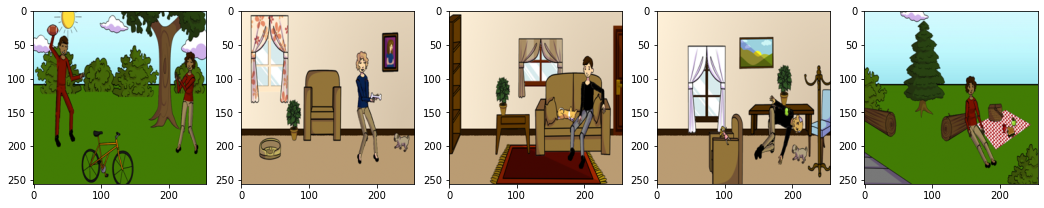

In [ ]:
count=0
print("test")

fig,ax=plt.subplots(1,5, figsize=(18,6))

# First 5 data: we print for each: question, answer, picture
while count<5:
    #get data
    inputs, outputs = next(test_gen)
    #predict
    pred = model.predict(inputs)
    #inverse map encoding
    print(list(map(sequence_to_text, inputs[1])))
    #show image
    ax[count].imshow(inputs[0].reshape((256, 256, 3)))
    #find output
    a = np.array(pred)
    x=np.argmax(a)
    print(classes[int(x)])
    count = count +1 

Generate results for test set by choosing the argmax of the softmax for every test data

In [ ]:
test_gen = test_generator()
results = {}
count = 0 

for i in range(6372):
    #get data
    inputs, outputs = next(test_gen)
    #get predictions
    pred = model.predict(inputs)
    results[outputs]=np.argmax(pred)
    #print(count) for debug
    count = count +1 

Create submission file

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
create_csv(results,'/content/drive/My Drive')